# Predicting Future Bid Ask Spreads based in Historical Data and then Trade and Quote Data

For this project, I explored a collection of data that contained both historical and trade and quote (T and Q) information about a variety of shares traded in the market. In this work, I show 

- linear and non-linear correlations between the various features in the data set to develop a heuristic on how the future spread should depend on the various characteristics of the data. 

- identification of relevant variables through the use of various linear regression techniques

- an observed data collapse when normalizing spread by median width

- an attempt to fit future spread using gradient boosting and random forests

- an attempt to fit future spread using Deep Neural Networks

Through this presentation, I try to present plots to provide intuition about how future spread should evolve as a function of time of day given the various attributes of a given symbol.

In particular, I propose the following few models for predicting future spread.


$\log(\text{fut_spread})=\alpha_{1}^{\text{(symbol type)}}\log(\text{time of day})+\alpha_{2}^{\text{(symbol type)}}\log(\text{median width})+\alpha_{3}^{\text{(symbol type)}}$

$\log(\text{fut_spread})=\alpha_{1}^{\text{(symbol type)}}\log(\text{time of day})+\alpha_{2}^{\text{(symbol type)}}\log(\text{median width})+\alpha_{3}^{\text{(symbol type)}}\log(\text{spread}) + \alpha_{4}^{\text{symbol type}}$

In the collapsed code blocks below, I have included several useful functions and imported all the relevant packages and classes I needed for this analysis. Feel free to take a look

In [53]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn.decomposition import PCA

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [104]:
def normalizeSpread(spread, ask): #making a function to convert spreads from price space to percentage space, and eliminating all negative spreads
    if ask==0:
        return np.nan
    elif ask>0:
        return float(spread/ask)
    #elif spread<0:
    #    return 0.
    
def splitData(data, features, target, test_fraction, set_seed=False):
    #splitting data into train and test
    x=data[features]
    y=data[target]
    if set_seed==True:
        x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=test_fraction, shuffle=True, random_state='12262021')
    else:
        x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=test_fraction, shuffle=True)
    return (x_train, x_test, y_train, y_test)

def LassoFitter(x_train, y_train, alpha):
    ##perform LASSO fit and return a class that contains parameters for LASSO fitting
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)
    return Lasso_fit

def RidgeFitter(x_train, y_train, alpha):
    ##perform Ridge fit and return a class that contains parameters for inferred Ridge fit
    Ridge_fit=Ridge(alpha, normalize=True).fit(x_train, y_train)
    
    return Ridge_fit

def build_and_compile_model(norm):
    ##baseline model for DNN fitting. Loss can be changed to mean squared error or mean absolute error
    
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

## Preprocessing and cleaning the data

I now read in the dataset and extract the static and the trade and quote features. In addition, I create a new feature for the dataset called 'ordinal_times'. This feature is a number that tells us from which 10 minute interval during the trading day our data is taken. This will be useful for our neural nets and random forests, who don't need to know the time, exactly, but do need to know the relative ordering of the times, and the relative differences.

In [3]:
DataSet=pd.read_parquet("spreads_data_train.par")
DataSet=DataSet.sort_values(by='localtime')

tickers=list(DataSet['symbol'].unique())

DataSet=DataSet.rename_axis("ordinal_times").reset_index()

FeatureSet=pd.read_csv('data_descriptions.csv')
staticFeatures=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
allNumericalFeatures=staticFeatures+TandQFeatures

In [4]:
print('the static features are ',staticFeatures)
print('the trade and quote features are ', TandQFeatures)

the static features are  ['volatility', 'avg_daily_volume', 'avg_daily_notional', 'median_daily_volume', 'median_daily_notional', 'mean_width', 'median_width', 'median_nbbo_size', 'opening_price', 'closing_price', 'ordinal_times']
the trade and quote features are  ['bid', 'ask', 'bidsize', 'asksize', 'mid', 'spread', 'open', 'high', 'low', 'close', 'volume', 'numEvents', 'notional_volume']


I include a few additional features, that are relatively simple, for exploratory data analysis purposes. In particular, I normalize the spreads, so I can compare across tickers with dramatically different underlying prices

In [5]:
DataSet['normalized_spread']=DataSet.apply(lambda row: normalizeSpread(row['spread'],row['ask']), axis=1)
DataSet['normalized_fut_spread']=DataSet.apply(lambda row: normalizeSpread(row['fut_spread'],row['ask']), axis=1)
DataSet['dayofweek']=DataSet['localtime'].dt.dayofweek
DataSet['recip_ordinal_times']=DataSet.apply(lambda row: 1./(1+row['ordinal_times']), axis=1)

I peek into the data to search for any missing or otherwise strange values. In particular, I note that there are several rows with missing entries due to <b> the number of events in a given 10 minute window being 0 </b>. This can be a consequence of the ticker not yet trading, just having a ticker change, or low liquidity. For simplicity, I'll omit such events.

I'll note that missing data may not be a problem in general. Such issues can be dealt with by random forests and gradient boosting learning algorithms, through the use of imputation, so I may return to them later. However, for now, <b> I completely remove any row with a missing entry </b>.

The tickers with missing entries are listed below. The second list is the tickers that have missing entries other than numEvents. Note that most of them have recently IPO'd. <b>The exception is CTRA</b>, which appears to not have its symbol type filled in. I did a quick google search and guessed it was a common stock so I filled it in for convenience. 



In [6]:
print(DataSet[DataSet.isna().any(axis=1)==True]['symbol'].unique())
print(DataSet[(DataSet.isna().any(axis=1)==True) & (DataSet['numEvents']>0)]['symbol'].unique())

['CTRA' 'AFRM' 'PLTK' 'STLA' 'AXON' 'NOK' 'CLVT' 'AEE' 'CCJ' 'HPQ' 'MPC'
 'TFII' 'PCOR' 'ARGX' 'SOFI' 'BIIB' 'MNDY' 'IWV' 'TTE' 'BZ' 'DFAC' 'GRUB'
 'YMM' 'DIDI' 'GIB' 'QGEN' 'LCID' 'HOOD']
['CTRA' 'AFRM' 'PLTK' 'STLA' 'AXON' 'CLVT' 'PCOR' 'SOFI' 'MNDY' 'TTE' 'BZ'
 'DFAC' 'YMM' 'DIDI' 'LCID' 'HOOD']


Continuing further, I note a few more data anomalies.
- ZBRA appears to have its ask price on a particular day as being listed as one percent of what it should be. I couldn't independently verify that it was exactly one percent though, so I just dropped that particular day.
- the spreads in general sometimes drop to negative values. I couldn't justify to myself that this should ever be the case, and some economics literature I read suggested those values should be assumed to be 0. I was, however, uncomfortable directly manipulating the target data, so I simply dropped all negative values from the data set. This may cause problems later, as I may not train on enough zeros, but that will have to be acceptable for now. For now, I restricted the data to places where the spread is never less than (-20%) of the last best ask, BUT later, I may omit negative spreads entirely.  
- MSFT, AAPL, and a few the other tickers appear to have single instance events where the close or open appears to be significantly off what it should be. I left these alone, as it seemed computationally expensive to search through the entire data set, looking for instances where the ratio of the open, close, bid, ask, etc prices from timepoint (t) to timepoint (t+1) appears significantly away from what it should be.
- TTD experiences a stock split during the interval. I am not sure if any other tickers had stock splits in this interval but I would like to edit the entire dataset in such a way that TTD's historicals reflect the stock split as though it had always been that way. However, I left this alone for now.
- Lastly, an interval of the dataset was omitted entirely. I identify what date range below.


In [7]:
DataSet=DataSet[DataSet['numEvents']>0]
DataSet.loc[DataSet['symbol']=='CTRA','symbol_type']='Common Stock'
DataSet[DataSet['symbol']=='CTRA']
DataSet=DataSet.dropna()
DataSet=DataSet[(DataSet['normalized_fut_spread']>0) & (DataSet['normalized_spread']>0)]

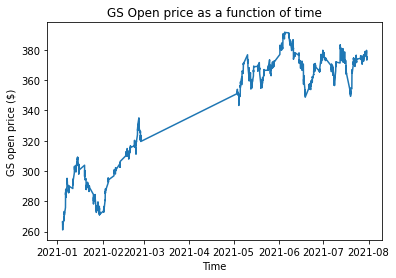

In [8]:
plt.plot(DataSet[DataSet['symbol']=='GS']['localtime'], DataSet[DataSet['symbol']=='GS']['close'])
plt.xlabel('Time')
plt.ylabel('GS open price ($)')
plt.title('GS Open price as a function of time')
plt.show()

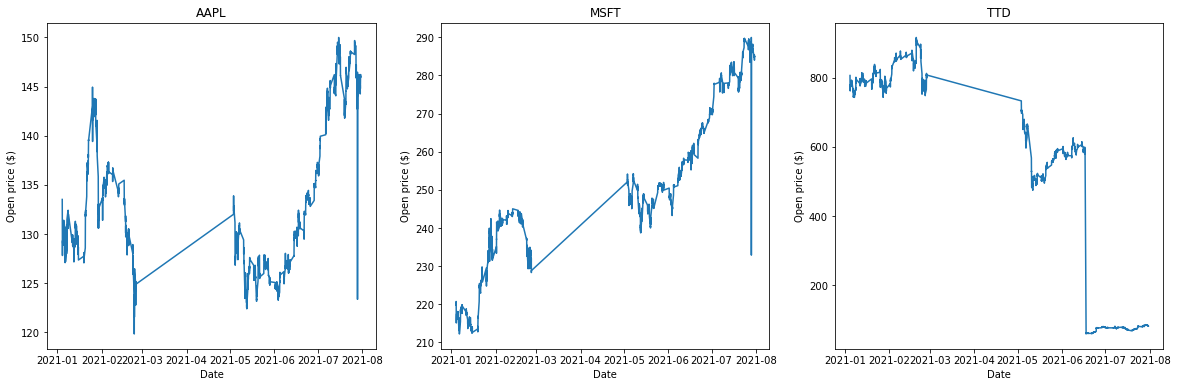

In [9]:
fig, axs=plt.subplots(1,3)
fig.set_size_inches(20,6)
axs[0].plot(DataSet[DataSet['symbol']=='AAPL']['localtime'], DataSet[DataSet['symbol']=='AAPL']['open'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Open price ($)')
axs[0].set_title('AAPL')

axs[1].plot(DataSet[DataSet['symbol']=='MSFT']['localtime'], DataSet[DataSet['symbol']=='MSFT']['close'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Open price ($)')
axs[1].set_title('MSFT')

axs[2].plot(DataSet[DataSet['symbol']=='TTD']['localtime'], DataSet[DataSet['symbol']=='TTD']['open'])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Open price ($)')
axs[2].set_title('TTD')
plt.show()

In [10]:
start_date=min(DataSet['date'])
end_date=max(DataSet['date'])
missing_dates=pd.date_range(start=start_date, end=end_date, freq='B').difference(DataSet['date'])
print('the start date is ',start_date)
print('the end date is ',end_date)
print('these are the missing dates, including some federal holidays ',missing_dates)

the start date is  2021-01-04
the end date is  2021-07-30
these are the missing dates, including some federal holidays  DatetimeIndex(['2021-01-18', '2021-02-10', '2021-02-11', '2021-02-15',
               '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-05', '2021-03-08', '2021-03-09', '2021-03-10',
               '2021-03-11', '2021-03-12', '2021-03-15', '2021-03-16',
               '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-22',
               '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
               '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01',
               '2021-04-02', '2021-04-05', '2021-04-06', '2021-04-07',
               '2021-04-08', '2021-04-09', '2021-04-12', '2021-04-13',
               '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19',
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30',

## Exploratory Data Analysis

I now wanted to take a look at the future spread as a function of the ordinal time of the day for symbols of different types. I note that in general, there appears to be a downward trend throughout the day, and at least for the examples I chose, there appear to be different ranges over which the spread varies

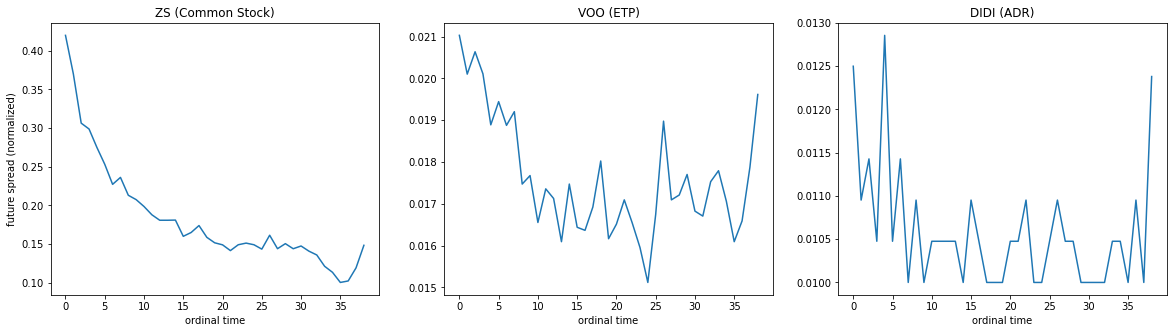

In [11]:
ZS=DataSet[DataSet['symbol']=='ZS'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
VOO=DataSet[DataSet['symbol']=='VOO'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
DIDI=DataSet[DataSet['symbol']=='DIDI'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
fig, axs=plt.subplots(1,3, sharex=True)

fig.set_size_inches(20,5)

axs[0].plot(ZS['fut_spread'])
axs[0].set_xlabel('ordinal time')
axs[0].set_ylabel('future spread (normalized)')
axs[0].set_title('ZS (Common Stock)')

axs[1].plot(VOO['fut_spread'])
axs[1].set_xlabel('ordinal time')
axs[1].set_title('VOO (ETP)')

axs[2].plot(DIDI['fut_spread'])
axs[2].set_xlabel('ordinal time')
axs[2].set_title('DIDI (ADR)')

plt.show()

There appears to be very little trend in the behavior of spread as a function of day of the week.

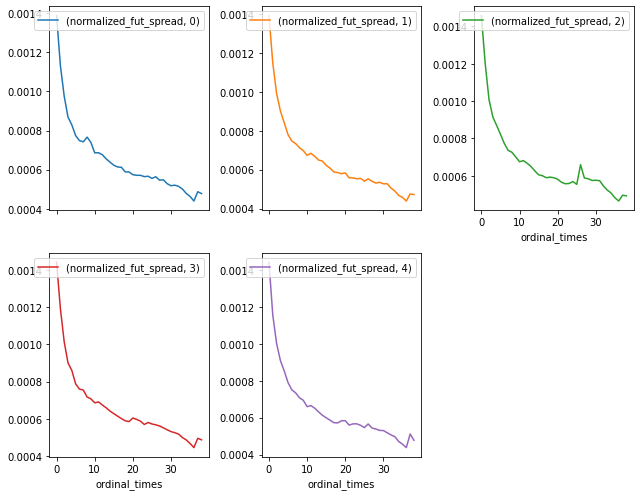

In [12]:
dayofweekspread=DataSet[['normalized_fut_spread', 'dayofweek', 'ordinal_times']].groupby(['dayofweek','ordinal_times']).mean()
ax = dayofweekspread.unstack(level=0).plot(kind='line', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

Further, I note the distribution appears to have something of a power-law like fall off in frequency.

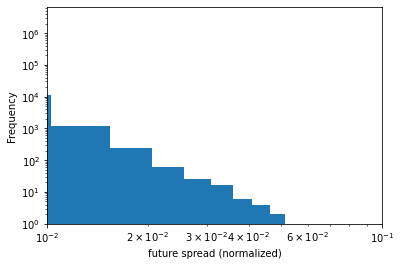

In [13]:
plt.hist(DataSet['normalized_fut_spread'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('future spread (normalized)')
plt.ylabel('Frequency')
plt.xlim(10**-2,10**-1)
plt.show()

When comparing spread against future spread, I observe the following: 


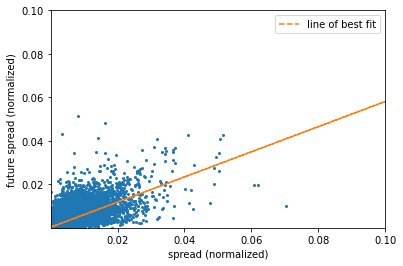

In [228]:
plt.plot(DataSet['normalized_spread'],DataSet['normalized_fut_spread'],ls='none', Marker='.', ms=4)
fit=np.polyfit(DataSet['normalized_spread'],DataSet['normalized_fut_spread'], 1)
plt.plot(DataSet['normalized_spread'], fit[0]*DataSet['normalized_spread']+fit[1], ls='--', label='line of best fit')
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('spread (normalized)')
plt.ylabel('future spread (normalized)')
plt.xlim(10**-5,0.1)
plt.ylim(10**-5,0.1)
plt.show()

Below, we have our first interesting result. <b> It appears that for smaller bid and ask sizes, the spread tends to have a larger variance than for larger bid and ask sizes </b>

(0.0, 0.1)

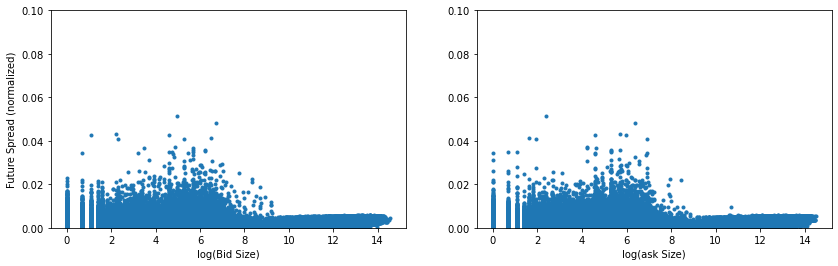

In [14]:
fig, axs=plt.subplots(1,2)
fig.set_size_inches(14,4)
axs[0].plot(np.log(DataSet['bidsize']), DataSet['normalized_fut_spread'], ls='none', Marker='.', MarkerSize=6)
axs[0].set_xlabel('log(Bid Size)')
axs[0].set_ylabel('Future Spread (normalized)')
axs[0].set_ylim(0,0.1)

axs[1].plot(np.log(DataSet['asksize']), DataSet['normalized_fut_spread'], ls='none', Marker='.', MarkerSize=6)
axs[1].set_xlabel('log(ask Size)')
axs[1].set_ylim(0,0.1)

Now, I'll characterize some of the various features correlation coefficients with the future spread. I note that this measure only captures linear relationships, so non linear relationships may remain hidden in the data. <b>We observe that future spread has strong linear correlations with indicators correlated with the true price of the symbol, the median width of the spread, and the previous spread. Notably, ordinal time and the reciprocal of ordinal times appears to be very poorly correlated with the future spread.</b>

In [15]:
DataSet.corr()['fut_spread']

ordinal_times           -0.066620
bid                      0.702829
ask                      0.703635
bidsize                 -0.036163
asksize                 -0.036752
mid                      0.703232
spread                   0.860707
open                     0.703193
high                     0.704024
low                      0.702686
close                    0.703228
volume                  -0.046998
numEvents               -0.034903
notional_volume          0.006574
volatility               0.019232
avg_daily_volume        -0.074347
avg_daily_notional       0.002051
median_daily_volume     -0.079782
median_daily_notional    0.001923
mean_width               0.023923
median_width             0.859819
median_nbbo_size        -0.039676
opening_price            0.704258
closing_price            0.703705
fut_spread               1.000000
normalized_spread        0.297874
normalized_fut_spread    0.409448
dayofweek                0.000967
recip_ordinal_times      0.076929
Name: fut_spre

Some of these correlations may be high because there are correlations amongst the predictor features as well. If we focus exclusively on static features, we see that the open and close price have strong correlations, so when one is correlated to future spread, the other will be as well. 

<b> Surprisingly, volume and volatility are only weakly linearly correlated with the data, even though spread is typically thought to be a measure of liquidity </b>. 

I would have expected spread to be negatively correlated with volume, because when volume is high, many people are performing price discovery, so the market is fairly certain of price, driving spreads to be low, and vice versa for low volumes. I would expect volatility to be positively correlated with spread, as high volatility may cause people to be very uncertain of the price, causing divergences between bidders and askers to grow, and vice versa for low volatility. I will explore why this is the case.

In [16]:
DataSet[staticFeatures+['fut_spread']+['recip_ordinal_times']].corr()

,volatility,avg_daily_volume,avg_daily_notional,median_daily_volume,median_daily_notional,mean_width,median_width,median_nbbo_size,opening_price,closing_price,ordinal_times,fut_spread,recip_ordinal_times
volatility,1.000000,0.247031,0.072569,0.202399,0.044974,0.003184,0.020348,0.007606,-0.026140,-0.026626,0.001073,0.019232,-0.001092
avg_daily_volume,0.247031,1.000000,0.457935,0.977716,0.422859,0.016321,-0.078667,0.258526,-0.097359,-0.097534,0.000577,-0.074347,-0.000525
avg_daily_notional,0.072569,0.457935,1.000000,0.483875,0.995043,0.006121,0.005801,-0.001882,0.209113,0.209190,0.000059,0.002051,0.000029
median_daily_volume,0.202399,0.977716,0.483875,1.000000,0.459740,0.020033,-0.084416,0.270495,-0.101848,-0.102000,0.000570,-0.079782,-0.000487
median_daily_notional,0.044974,0.422859,0.995043,0.459740,1.000000,0.006807,0.005647,-0.001317,0.210238,0.210363,0.000039,0.001923,0.000056
mean_width,0.003184,0.016321,0.006121,0.020033,0.006807,1.000000,0.024536,-0.001755,0.017015,0.017086,0.000027,0.023923,-0.000022
median_width,0.020348,-0.078667,0.005801,-0.084416,0.005647,0.024536,1.000000,-0.041984,0.798089,0.797099,0.000474,0.859819,-0.000414
median_nbbo_size,0.007606,0.258526,-0.001882,0.270495,-0.001317,-0.001755,-0.041984,1.000000,-0.082501,-0.082550,0.000281,-0.039676,-0.000284
opening_price,-0.026140,-0.097359,0.209113,-0.101848,0.210238,0.017015,0.798089,-0.082501,1.000000,0.999802,0.000294,0.704258,-0.000239
closing_price,-0.026626,-0.097534,0.209190,-0.102000,0.210363,0.017086,0.797099,-0.082550,0.999802,1.000000,0.000292,0.703705,-0.000238


Before diving any deeper, however, I'd like to explore this correlation matrix for a particular symbol or two. I'll look at AAPL and IAC. I note that for AAPL, all the correlations tend to be pretty weak, but for IAC, there are strong correlations all over the place. Notably, IAC appears to have time correlations!

In [17]:
print('AAPL future spread correlations...')
DataSet[DataSet['symbol']=='AAPL'][staticFeatures+['ordinal_times']+['fut_spread']+['recip_ordinal_times']].corr()['fut_spread']

AAPL future spread correlations...


volatility               0.220316
avg_daily_volume         0.217390
avg_daily_notional       0.214133
median_daily_volume      0.208773
median_daily_notional    0.210524
mean_width               0.272402
median_width             0.188796
median_nbbo_size        -0.191222
opening_price            0.072970
closing_price            0.068884
ordinal_times           -0.004614
ordinal_times           -0.004614
fut_spread               1.000000
recip_ordinal_times      0.107043
Name: fut_spread, dtype: float64

In [18]:
print('IAC future spread correlations...')
DataSet[DataSet['symbol']=='IAC'][staticFeatures+['ordinal_times']+['fut_spread']+['recip_ordinal_times']].corr()['fut_spread']

IAC future spread correlations...


volatility              -0.223709
avg_daily_volume        -0.250826
avg_daily_notional       0.020823
median_daily_volume     -0.255034
median_daily_notional    0.030584
mean_width               0.421930
median_width             0.430318
median_nbbo_size        -0.272718
opening_price            0.404124
closing_price            0.397041
ordinal_times           -0.432351
ordinal_times           -0.432351
fut_spread               1.000000
recip_ordinal_times      0.506825
Name: fut_spread, dtype: float64

I'll now directly plot future spread against volume, volatility, and ordinal times across all tickers. I note that it appears as though volume and volatility are correlated with future spread, but in a non linear way. Ordinal times also shows some structure, but it's quite weak. Surprisingly, the variance in spread decreases as volume rises. This may be due to a number of things - one of which is that stocks that are highly volatile may also have high volume.

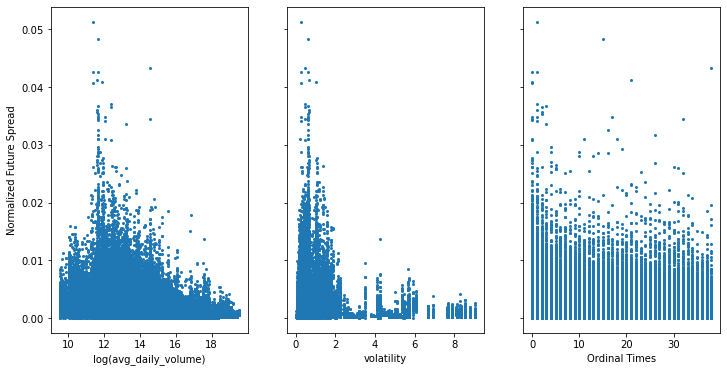

In [19]:
fig, axs=plt.subplots(1,3, sharey=True)
fig.set_size_inches(12,6)
axs[0].plot(np.log(DataSet['avg_daily_volume']), DataSet['normalized_fut_spread'],ls='none', Marker='.',MarkerSize=4)
axs[0].set_ylabel('Normalized Future Spread')
axs[0].set_xlabel('log(avg_daily_volume)')

axs[1].plot(DataSet['volatility'], DataSet['normalized_fut_spread'],ls='none', Marker='.',MarkerSize=4)
axs[1].set_xlabel('volatility')

axs[2].plot(DataSet['ordinal_times'], DataSet['normalized_fut_spread'], ls='none', Marker='.', MarkerSize=4)
axs[2].set_xlabel('Ordinal Times')
plt.show()

I'm interested now in plotting the spreads for tickers in a manner that explores all combinations of (high, medium, low) and (volatility,volume). That way, I can really understand how this system behaves. I'll plot exclusively common stocks for now, so I don't get confused by effects due to symbol type.

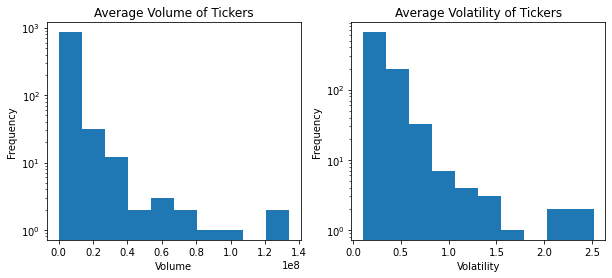

In [20]:
avg_by_ticker=DataSet[['symbol','avg_daily_volume','volatility']].groupby('symbol').mean()
avg_by_ticker.head()
fig, axs=plt.subplots(1,2)
fig.set_size_inches(10,4)
axs[0].set_title('Average Volume of Tickers')
axs[0].hist(avg_by_ticker['avg_daily_volume'])
axs[0].set_yscale('log')
axs[0].set_xlabel('Volume')
axs[0].set_ylabel('Frequency')
axs[1].hist(avg_by_ticker['volatility'])
axs[1].set_xlabel('Volatility')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Average Volatility of Tickers')
axs[1].set_yscale('log')
plt.savefig('vol_vol_freq_plot_per_ticker.pdf')

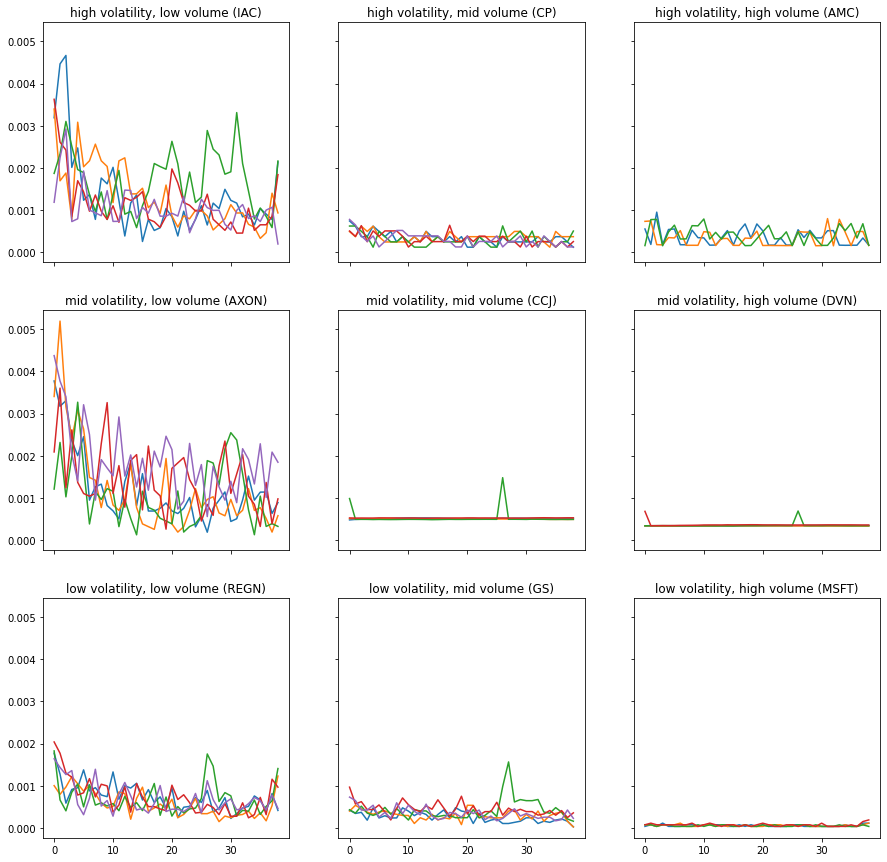

In [21]:
fig, ax=plt.subplots(3,3, sharex=True, sharey=True)
fig.set_size_inches(15,15)

minutes_since_open=DataSet['ordinal_times'].unique()
dates_to_plot=[datetime.date(2021,6,14),datetime.date(2021,6,15),datetime.date(2021,6,16),datetime.date(2021,6,17),datetime.date(2021,6,18)]

ticker_of_int='IAC'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[0,0].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[0,0].set_title('high volatility, low volume (IAC)')

ticker_of_int='CP'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[0,1].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[0,1].set_title('high volatility, mid volume (CP)')

ticker_of_int='AMC'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[0,2].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[0,2].set_title('high volatility, high volume (AMC)')

ticker_of_int='AXON'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[1,0].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[1,0].set_title('mid volatility, low volume (AXON)')

ticker_of_int='CCJ'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[1,1].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[1,1].set_title('mid volatility, mid volume (CCJ)')

ticker_of_int='DVN'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[1,2].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[1,2].set_title('mid volatility, high volume (DVN)')

ticker_of_int='REGN'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[2,0].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[2,0].set_title('low volatility, low volume (REGN)')

ticker_of_int='GS'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[2,1].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[2,1].set_title('low volatility, mid volume (GS)')

ticker_of_int='MSFT'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[2,2].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[2,2].set_title('low volatility, high volume (MSFT)')

plt.savefig('Volatility_vs_Volume.pdf')

Now it seems apparent - low volume stocks tend to have more structure in the behavior of spread against time, while high volume stocks tend to be very small and constant throughout the day, even for highly volatile stocks.

I'll now inspect how future spread depends on the symbol type.

In [22]:
avg_by_symbol_type=DataSet[['symbol_type','avg_daily_volume','volatility','fut_spread']].groupby('symbol_type').mean()
std_by_symbol_type=DataSet[['symbol_type','avg_daily_volume','volatility','fut_spread']].groupby('symbol_type').std()
avg_and_std_by_symbol_type=pd.merge(avg_by_symbol_type, std_by_symbol_type, on='symbol_type', suffixes=('_avg', '_std'))
avg_and_std_by_symbol_type

,avg_daily_volume_avg,volatility_avg,fut_spread_avg,avg_daily_volume_std,volatility_std,fut_spread_std
symbol_type,,,,,,
ADR,6.729040e+06,0.385499,0.063461,1.527040e+07,0.303837,0.189559
Common Stock,3.479819e+06,0.326581,0.166805,9.196941e+06,0.325911,0.610921
ETP,4.788620e+06,0.162414,0.029905,9.098183e+06,0.086231,0.045162
Ltd Part,2.403466e+05,0.149166,0.041311,4.740135e+04,0.033897,0.019937
MLP,5.223539e+06,0.261230,0.035309,6.416160e+06,0.076364,0.051603
NY Reg Shrs,1.811098e+06,0.360900,0.117271,1.538434e+06,0.097086,0.204124
REIT,1.783624e+06,0.262028,0.073727,2.177627e+06,0.338662,0.138918
Tracking Stk,6.075667e+05,0.265130,0.051341,1.210284e+05,0.060252,0.039726


<b>I note that the symbol types appear to belong to very distinct distributions</b>. Volume in ADRs can be very high and exhibit high variance compared to volume in common stocks. In addition, volatility tends to be significantly lower in ETPs than all other stocks. Both of these observations appear to have consequences for future spread, which appears to have distinctly different distributions from common stocks to ETPs to ADRs. Taking a look at the data, this appears to bear out.

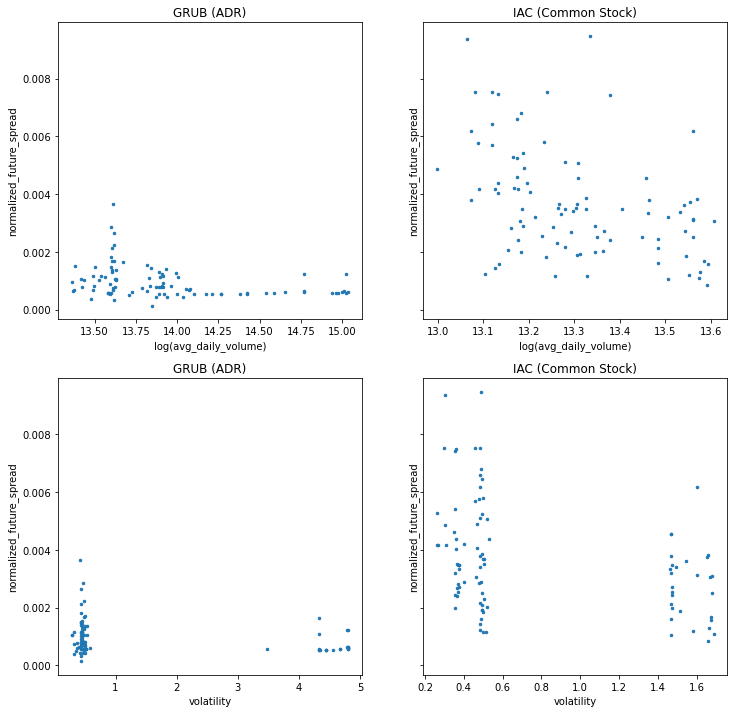

In [23]:
fig, axs=plt.subplots(2,2, sharey=True)
fig.set_size_inches(12,12)
axs[0,0].plot(np.log(DataSet[(DataSet['symbol']=='GRUB') & (DataSet['ordinal_times']==0)]['avg_daily_volume']), DataSet[(DataSet['symbol']=='GRUB')  & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[0,0].set_xlabel('log(avg_daily_volume)')
axs[0,0].set_ylabel('normalized_future_spread')
axs[0,0].set_title('GRUB (ADR)')

axs[0,1].plot(np.log(DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['avg_daily_volume']), DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[0,1].set_xlabel('log(avg_daily_volume)')
axs[0,1].set_ylabel('normalized_future_spread')
axs[0,1].set_title('IAC (Common Stock)')

axs[1,0].plot(DataSet[(DataSet['symbol']=='GRUB') & (DataSet['ordinal_times']==0)]['volatility'], DataSet[(DataSet['symbol']=='GRUB') & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[1,0].set_xlabel('volatility')
axs[1,0].set_ylabel('normalized_future_spread')
axs[1,0].set_title('GRUB (ADR)')

axs[1,1].plot(DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['volatility'], DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[1,1].set_xlabel('volatility')
axs[1,1].set_ylabel('normalized_future_spread')
axs[1,1].set_title('IAC (Common Stock)')
plt.show()

Finally, I'll end the EDA on something of a surprising observation. There appears to be a data collapse for common stocks, where there is a convergence of the future spread fall offs when I standardize by median width. To explore this more carefully, I'd like to see more data with more time resolution. It's not as clear that the same happens for ETPs or ADRs, but it's possible.

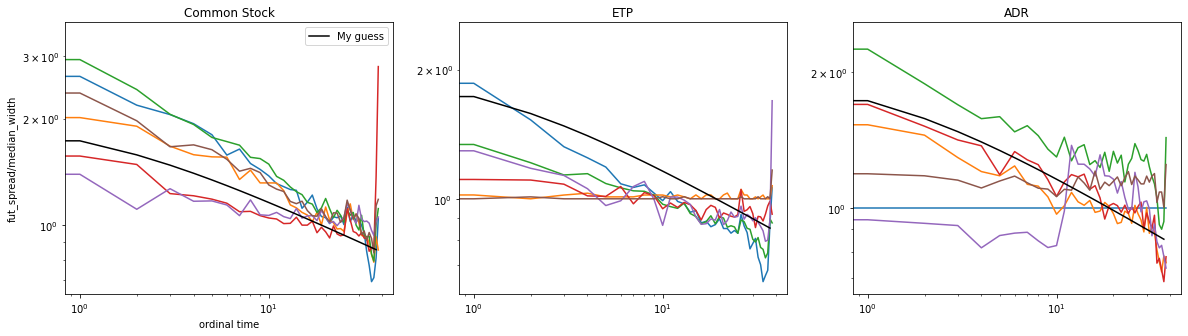

In [24]:
DataSet['fut_spread_by_width']=DataSet.apply(lambda row: row['fut_spread']/row['median_width'], axis=1)
fig, axs=plt.subplots(1,3, sharex=True)
fig.set_size_inches(20,5)
ZS=DataSet[DataSet['symbol']=='ZS'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
GS=DataSet[DataSet['symbol']=='GS'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IAC=DataSet[DataSet['symbol']=='IAC'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
MSFT=DataSet[DataSet['symbol']=='MSFT'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
OPEN=DataSet[DataSet['symbol']=='OPEN'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
REGN=DataSet[DataSet['symbol']=='REGN'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()





axs[0].plot(ZS['fut_spread_by_width'])
axs[0].plot(GS['fut_spread_by_width'])
axs[0].plot(IAC['fut_spread_by_width'])
axs[0].plot(MSFT['fut_spread_by_width'])
axs[0].plot(OPEN['fut_spread_by_width'])
axs[0].plot(REGN['fut_spread_by_width'])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].plot(2*np.linspace(1,30, num=38)**-0.25, color='black', label='My guess')
axs[0].set_title('Common Stock')
axs[0].set_xlabel('ordinal time')
axs[0].set_ylabel('fut_spread/median_width')
axs[0].legend()


VOT=DataSet[DataSet['symbol']=='VOT'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
EWJ=DataSet[DataSet['symbol']=='EWJ'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IWV=DataSet[DataSet['symbol']=='IWV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IVV=DataSet[DataSet['symbol']=='IVV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IWB=DataSet[DataSet['symbol']=='IWB'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
SPYV=DataSet[DataSet['symbol']=='SPYV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()



axs[1].plot(VOT['fut_spread_by_width'])
axs[1].plot(EWJ['fut_spread_by_width'])
axs[1].plot(IWV['fut_spread_by_width'])
axs[1].plot(IVV['fut_spread_by_width'])
axs[1].plot(IWB['fut_spread_by_width'])
axs[1].plot(SPYV['fut_spread_by_width'])

axs[1].plot(2*np.linspace(1,30, num=38)**-0.25, color='black')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('ETP')


ING=DataSet[DataSet['symbol']=='ING'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
BIDU=DataSet[DataSet['symbol']=='BIDU'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
XPEV=DataSet[DataSet['symbol']=='XPEV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
HDB=DataSet[DataSet['symbol']=='HDB'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
NGG=DataSet[DataSet['symbol']=='NGG'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
LU=DataSet[DataSet['symbol']=='LU'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()



axs[2].plot(ING['fut_spread_by_width'])
axs[2].plot(BIDU['fut_spread_by_width'])
axs[2].plot(XPEV['fut_spread_by_width'])
axs[2].plot(HDB['fut_spread_by_width'])
axs[2].plot(NGG['fut_spread_by_width'])
axs[2].plot(LU['fut_spread_by_width'])

axs[2].plot(2*np.linspace(1,30, num=38)**-0.25, color='black')

axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_title('ADR')

plt.show()

## Linear Modeling both Static Features and All Features
### A high bias-low variance approach

I will attempt to model the future spread of each ticker through the use of linear regression methods. For the purposes of this analysis, I will show a few fits of the data for particular tickers, and then I will try to fit all stocks sharing the same symbol type using the same linear regression model. 

For fitting, I will use Lasso Regression and Ridge Regression. I chose these regression techniques over other linear regression techniques due to the highly correlated structure within the predictor features. The regularization used by both of these techniques provides different ways of treating this underlying issue. Notably, Lasso regression can be used to identify a hierarchical ordering in the importance of each predictor. 

To quantify the error across models with different tickers and symbol types, I will keep track of
$\sigma_{\hat{y}-y} / \sigma_{y}$, where $\hat{y}$ is our predicted future spread based on our regression and $y$ is our future spread. This quantification tells us what fraction of error our model provides compared to guessing just the mean spread at each time point.

I'll note that I have chosen not to fit this data using an ARIMA model. I made this choice because the correlation between 'spread' and 'fut_spread' was approximately 0.85, meaning that most of the information about the past was already coming through in a linear correlation in spread. Considering further time points back may have been useful, but it was unlikely to provide significant improvements in accuracy, due to the relatively low time resolution of the data. However, with more time resolution, I would strongly expect ARIMA models to fit the data better.

Lastly, in each attempt, I split the data into a train set and test set. This is to simply keep an eye on generalization.

We will begin with Ridge Regression on a particular ticker. In addition, we will extend our static features to include ordinal times and the reciprocal of ordinal times.

In [25]:
staticFeatures=staticFeatures+['recip_ordinal_times']
allNumericalFeatures=allNumericalFeatures+['recip_ordinal_times']

the error is... 0.6942852445879591


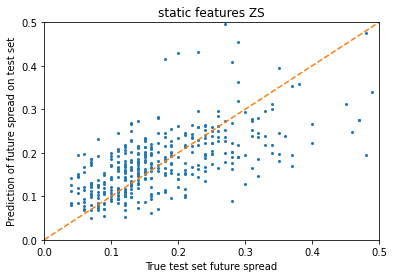

In [40]:
x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol']=='ZS'], staticFeatures, 'fut_spread', 0.1)

Predictor=Ridge(alpha=0.00001,normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol']=='ZS')]['fut_spread'].std())

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([0,1],[0,1],ls='--')
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.title('static features ZS')
plt.show()

Note that accurate predictions would sit along the dashed unity line. Repeating the above with all features provides very little improvement. Repeating with all features yields

the error is... 0.6625962919401862


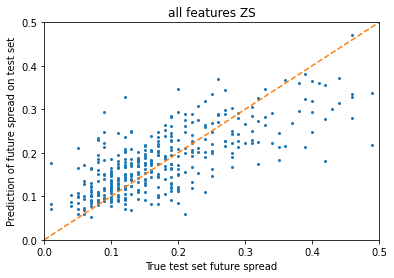

In [41]:
x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol']=='ZS'], allNumericalFeatures, 'fut_spread', 0.1)

Predictor=Ridge(alpha=0.00001,normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol']=='ZS')]['fut_spread'].std())

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([0,1],[0,1], ls='--')
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.title('all features ZS')
plt.show()

This does not represent a statistically significant improvement. We repeat with a different ticker.

the error is... 0.6820590202702832
the error is... 0.6648855829049476


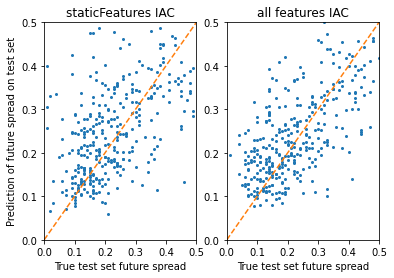

In [42]:
x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol']=='IAC'], staticFeatures, 'fut_spread', 0.1)

Predictor=Ridge(alpha=0.00001,normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol']=='IAC')]['fut_spread'].std())

fig,axs=plt.subplots(1,2)


axs[0].plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
axs[0].plot([0,1],[0,1],ls='--')
axs[0].set_ylabel('Prediction of future spread on test set')
axs[0].set_xlabel('True test set future spread')
axs[0].set_xlim(0,0.5)
axs[0].set_ylim(0,0.5)
axs[0].set_title('staticFeatures IAC')

x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol']=='IAC'], allNumericalFeatures, 'fut_spread', 0.1)

Predictor=Ridge(alpha=0.00001,normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol']=='IAC')]['fut_spread'].std())

axs[1].plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
axs[1].plot([0,1],[0,1],ls='--')
axs[1].set_xlabel('True test set future spread')
axs[1].set_xlim(0,0.5)
axs[1].set_ylim(0,0.5)
axs[1].set_title('all features IAC')



plt.show()

We see again, a small, but probably not statistically significant improvement. In addition, we see that we only reduce the error of our estimate by about 25-30%, as compared to simply guessing the mean at each time point. However, we can use this analysis to identify what factors the regression thinks is important.

In [50]:
x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol']=='IAC'], staticFeatures, 'fut_spread', 0.1)

Predictor=Ridge(alpha=0.00001,normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

coefficients=list(Predictor.coef_)

coefficients_dict={}

for index,name in enumerate(staticFeatures):
    coefficients_dict[name]=coefficients[index]
coefficients_dict

{'volatility': 0.039977932077904725,
 'avg_daily_volume': -3.0641924599589547e-07,
 'avg_daily_notional': 2.5905683470270272e-09,
 'median_daily_volume': -3.5869943491452647e-08,
 'median_daily_notional': -2.6846191905731043e-09,
 'mean_width': -0.5394891825727437,
 'median_width': 1.261368227635578,
 'median_nbbo_size': 9.459771609949114e-05,
 'opening_price': 0.001597644605628397,
 'closing_price': -0.0006523022948178665,
 'ordinal_times': -0.003770694536583283,
 'recip_ordinal_times': 0.44289501595905856}

We see that for training with <b>static features, the three most important features are median width, mean width, and the reciprocal of ordinal times</b>. Ordinal times, itself, was not useful. This makes sense, considering our observations about correlation earlier, as linear regression should fit to linear correlations and be unable to discover non-linear relationships within the data.

In [49]:
x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol']=='IAC'], allNumericalFeatures, 'fut_spread', 0.1)

Predictor=Ridge(alpha=0.00001,normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

coefficients=list(Predictor.coef_)

coefficients_dict={}

for index,name in enumerate(allNumericalFeatures):
    coefficients_dict[name]=coefficients[index]
coefficients_dict

{'volatility': 0.03363944986579536,
 'avg_daily_volume': -8.452524011342536e-08,
 'avg_daily_notional': 1.083593379803432e-09,
 'median_daily_volume': -1.4825839069584716e-07,
 'median_daily_notional': -1.5267816181857236e-09,
 'mean_width': -0.2177680054937021,
 'median_width': 0.712796542174679,
 'median_nbbo_size': 0.00011159528922952147,
 'opening_price': 0.0012662935252880374,
 'closing_price': -0.0009354434742229352,
 'ordinal_times': -0.0029093620174685734,
 'bid': 0.0038469239076319847,
 'ask': 0.0038383499538750658,
 'bidsize': -2.520713332890755e-05,
 'asksize': -2.8243838725189554e-05,
 'mid': 0.0038426630085836057,
 'spread': 0.189905541795096,
 'open': 0.010874900021844611,
 'high': 0.0006539266975215325,
 'low': -0.043078531251337086,
 'close': 0.02042136151788977,
 'volume': 3.770199225489351e-08,
 'numEvents': -2.7668746898793736e-06,
 'notional_volume': 8.762318025870957e-10,
 'recip_ordinal_times': 0.23703774390041304}

<b>When including trade and quote data, we continue to see that previous spread also plays a key role in predicting future spread</b>. No other variables become particularly important. 

An easier and more elegant way of identifying the relevant features is to use Lasso regression. With Lasso regression, coefficients sequentially rise above zero as the regularization constant falls. This provides a clear hierarchical ordering and enables us to ignore redundant variables. For example, we might expect that lasso regression would identify whether median or mean width is more important. We'll now fit the model to data for all belonging to the same symbol type. This is justified because the observed of the observed data collapse, and the distinct distributions to which each symbol type appears to have. <b> Essentially, I am assuming that intra-symbol type variability is significantly lower than inter-symbol type variability</b>.

We attempt a lasso regression sweeping across different regularization parameters.

In [54]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='Common Stock'
target='fut_spread'
testsize=0.1

coefficient_tracker=np.zeros((len(staticFeatures), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], staticFeatures, target, testsize)
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients     
    
coef_names=x_train.columns

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(coef_names))]

fig, axs=plt.subplots(1,2)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index], color=colors[index])
fig.set_size_inches(15,6)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')
axs[0].set_title('coefficients of regression, static fitting, common stocks')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_error, label='train')
axs[1].plot(alphas, test_error, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('RMSE normalized by target mean')
axs[1].set_xscale('log')
axs[1].set_title('coefficients of regression, static fitting, common stocks')


plt.show()

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79748.33089198616, tolerance: 86.0067925104141
  positive)
1it [01:09, 69.04s/it]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19634.120002633266, tolerance: 84.9687566807607
  positive)
10it [03:44, 22.46s/it]


We now see that the data for common stocks is mostly explained by just two variables - median_width and $\frac{1}{t}$. For other ETPs, we observe...

10it [00:11,  1.20s/it]


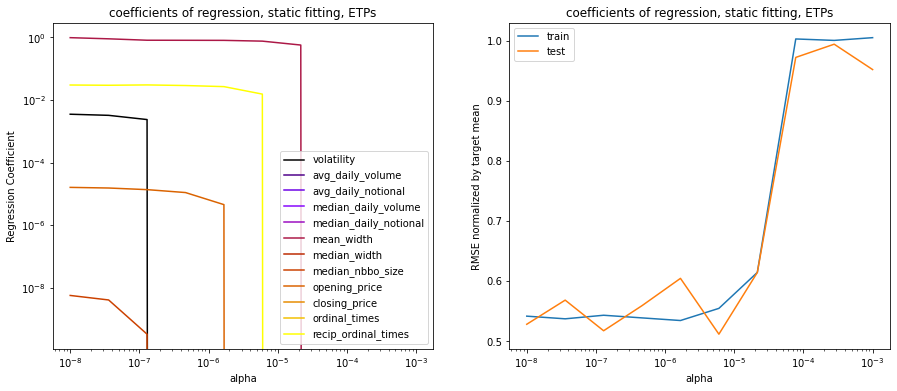

In [65]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='ETP'
target='fut_spread'
testsize=0.1

coefficient_tracker=np.zeros((len(staticFeatures), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], staticFeatures, target, testsize)
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients  
    
coef_names=x_train.columns

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(coef_names))]

fig, axs=plt.subplots(1,2)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index], color=colors[index])
fig.set_size_inches(15,6)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')
axs[0].set_title('coefficients of regression, static fitting, ETPs')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_error, label='train')
axs[1].plot(alphas, test_error, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('RMSE normalized by target mean')
axs[1].set_xscale('log')
axs[1].set_title('coefficients of regression, static fitting, ETPs')


plt.show()

Now, it appears only median width plays a role, with ordinal times being 1/100 as important. For ADRs, we observe...

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.68506001389824, tolerance: 0.9589355521110491
  positive)
10it [00:11,  1.17s/it]


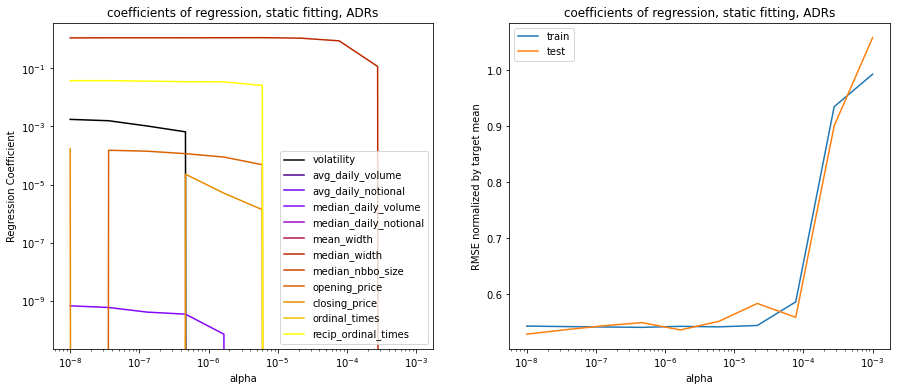

In [66]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='ADR'
target='fut_spread'
testsize=0.1

coefficient_tracker=np.zeros((len(staticFeatures), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], staticFeatures, target, testsize)
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients     
    
coef_names=x_train.columns

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(coef_names))]

fig, axs=plt.subplots(1,2)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index], color=colors[index])
fig.set_size_inches(15,6)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')
axs[0].set_title('coefficients of regression, static fitting, ADRs')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_error, label='train')
axs[1].plot(alphas, test_error, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('RMSE normalized by target mean')
axs[1].set_xscale('log')
axs[1].set_title('coefficients of regression, static fitting, ADRs')


plt.show()

This suggests that using static features only, the data is broadly explained by median width and the reciprocal of ordinal times. 

This leads me to proposing a new model:

$\log(\text{fut_spread}) = \alpha_{1} \log(\text{median_width}) + \alpha_{2} \log(\text{ordinal_times}) + \alpha_{3}$

In [67]:
DataSet['log_fut_spread']=DataSet.apply(lambda row: np.log(row['fut_spread']), axis=1)
DataSet['log_ordinal_times']=DataSet.apply(lambda row: np.log(row['ordinal_times']+1), axis=1)
DataSet['log_median_width']=DataSet.apply(lambda row: np.log(row['median_width']), axis=1)

the error is... 0.3416556753895761
the coefficient of log(ordinal_times) is... -0.2877815538165376
the coefficient of log(median_width) is... 0.9807379561034526


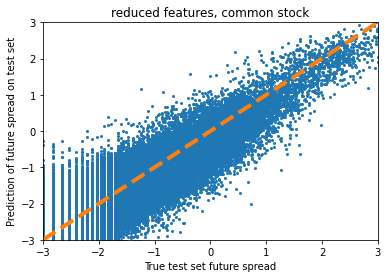

In [87]:
reduced_training_features=['log_ordinal_times', 'log_median_width']
target='log_fut_spread'
symbol_type='Common Stock'
testsize=0.1

x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], reduced_training_features, target, testsize)
Predictor=Ridge(alpha, normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol_type']==symbol_type)][target].std())

print('the coefficient of log(ordinal_times) is...', Predictor.coef_[0])
print('the coefficient of log(median_width) is...', Predictor.coef_[1])

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([-3,10],[-3,10], ls='--', LineWidth=4)
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('reduced features, common stock')
plt.show()

the error is... 0.42495605050936175
the coefficient of log(ordinal_times) is... -0.09675974065938706
the coefficient of log(median_width) is... 0.8901420909353638


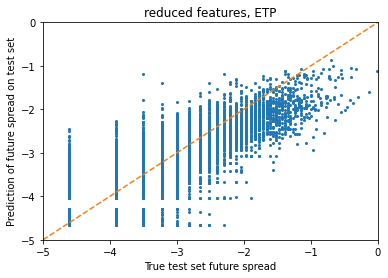

In [88]:
reduced_training_features=['log_ordinal_times', 'log_median_width']
target='log_fut_spread'
symbol_type='ETP'
testsize=0.1

x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], reduced_training_features, target, testsize)
Predictor=Ridge(alpha, normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol_type']==symbol_type)][target].std())

print('the coefficient of log(ordinal_times) is...', Predictor.coef_[0])
print('the coefficient of log(median_width) is...', Predictor.coef_[1])

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([-5,10],[-5,10], ls='--')
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(-5,0)
plt.ylim(-5,0)
plt.title('reduced features, ETP')
plt.show()

the error is... 0.3426208374610525
the coefficient of log(ordinal_times) is... -0.09234545296252838
the coefficient of log(median_width) is... 0.9710283143053436


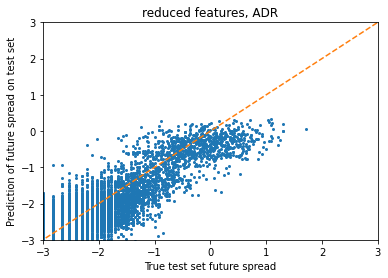

In [89]:
reduced_training_features=['log_ordinal_times', 'log_median_width']
target='log_fut_spread'
symbol_type='ADR'
testsize=0.1

x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], reduced_training_features, target, testsize)
Predictor=Ridge(alpha, normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol_type']==symbol_type)][target].std())

print('the coefficient of log(ordinal_times) is...', Predictor.coef_[0])
print('the coefficient of log(median_width) is...', Predictor.coef_[1])

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([-5,10],[-5,10], ls='--')
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('reduced features, ADR')
plt.show()

Our model appears to have born out quite well! And we observe significant improvements in our error using the proposed model.

We now can attempt to extend this to all numerical features to see if we can determine a model that takes into account any of the Trade and Quote features to obtain another improvement in RMSE.

We note that the relevant features are pretty similar, with the new addition of the need for spread. In addition, both spread AND median width are relevant, suggesting both need to be considered in a model to be predictive.

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60121.961836175666, tolerance: 85.6005584189022
  positive)
1it [02:39, 159.06s/it]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18145.61850977347, tolerance: 85.32830458690158
  positive)
10it [08:07, 48.72s/it]


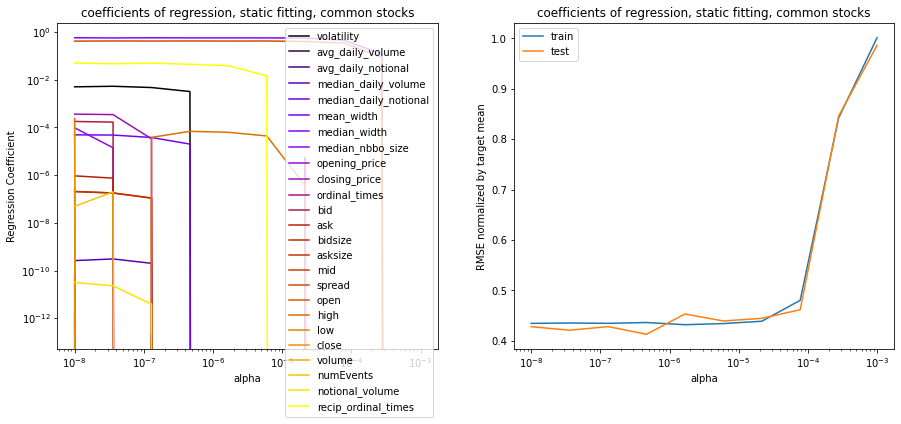

In [90]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='Common Stock'
target='fut_spread'
testsize=0.1

coefficient_tracker=np.zeros((len(allNumericalFeatures), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], allNumericalFeatures, target, testsize)
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients     
    
coef_names=x_train.columns

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(coef_names))]

fig, axs=plt.subplots(1,2)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index], color=colors[index])
fig.set_size_inches(15,6)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')
axs[0].set_title('coefficients of regression, static fitting, common stocks')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_error, label='train')
axs[1].plot(alphas, test_error, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('RMSE normalized by target mean')
axs[1].set_xscale('log')
axs[1].set_title('coefficients of regression, static fitting, common stocks')


plt.show()

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.85488490231957, tolerance: 0.05990442696193723
  positive)
10it [00:17,  1.77s/it]


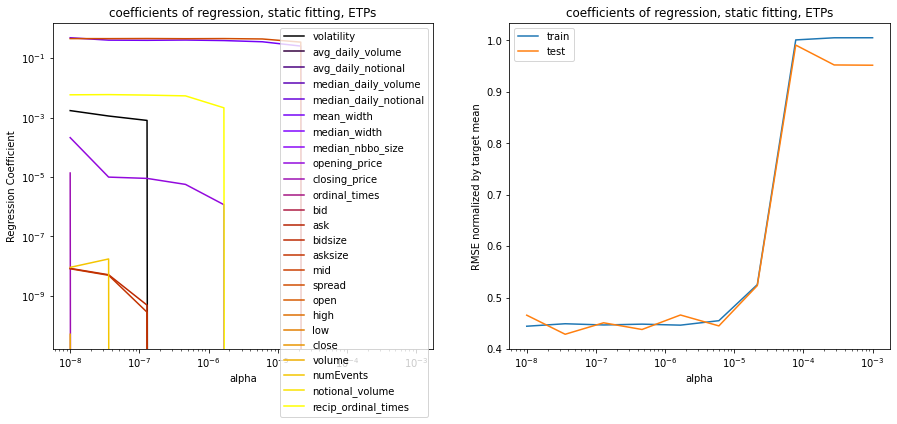

In [91]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='ETP'
target='fut_spread'
testsize=0.1

coefficient_tracker=np.zeros((len(allNumericalFeatures), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], allNumericalFeatures, target, testsize)
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients     
    
coef_names=x_train.columns

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(coef_names))]

fig, axs=plt.subplots(1,2)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index], color=colors[index])
fig.set_size_inches(15,6)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')
axs[0].set_title('coefficients of regression, static fitting, ETPs')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_error, label='train')
axs[1].plot(alphas, test_error, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('RMSE normalized by target mean')
axs[1].set_xscale('log')
axs[1].set_title('coefficients of regression, static fitting, ETPs')


plt.show()

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.5807400187477, tolerance: 0.961208523712344
  positive)
1it [00:05,  5.02s/it]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.1222074283653, tolerance: 0.953773265485193
  positive)
2it [00:09,  4.95s/it]/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7654720034861384, tolerance: 0.9641906377748827
  positive)
10it [00:22,  2.28s/it]


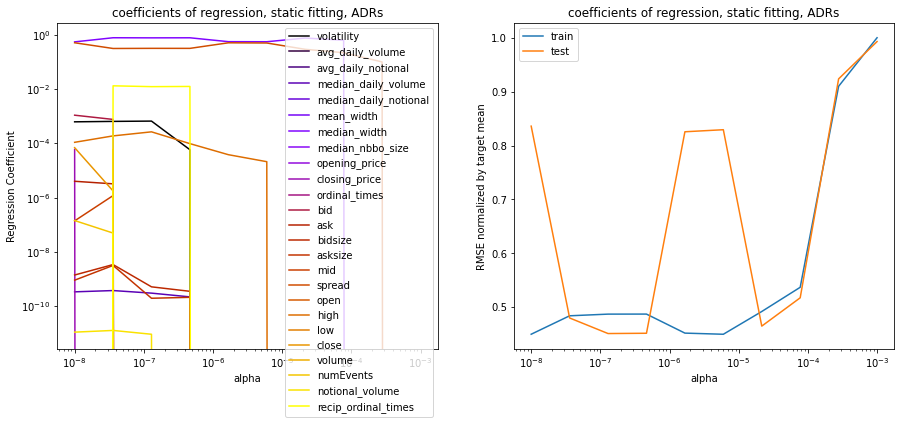

In [93]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='ADR'
target='fut_spread'
testsize=0.1

coefficient_tracker=np.zeros((len(allNumericalFeatures), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], allNumericalFeatures, target, testsize)
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']==symbol_type][target].std())
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients     
    
coef_names=x_train.columns

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(coef_names))]

fig, axs=plt.subplots(1,2)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index], color=colors[index])
fig.set_size_inches(15,6)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')
axs[0].set_title('coefficients of regression, static fitting, ADRs')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_error, label='train')
axs[1].plot(alphas, test_error, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('RMSE normalized by target mean')
axs[1].set_xscale('log')
axs[1].set_title('coefficients of regression, static fitting, ADRs')


plt.show()

So now, I'll propose a new model.

$\log(\text{fut_spread}) = \alpha_{1} \log(\text{median_width}) + \alpha_{2} \log(\text{ordinal_times}) + \alpha_{3}\log(\text{spread}) + \alpha_{4}$

In [94]:
DataSet['log_spread']=DataSet.apply(lambda row: np.log(row['spread']), axis=1)

the error is... 0.31625368534783665
the coefficient of log(ordinal_times) is... -0.1492450300037916
the coefficient of log(median_width) is... 0.5881702843396048
the coefficient of log(spread) is... 0.3967168190208681


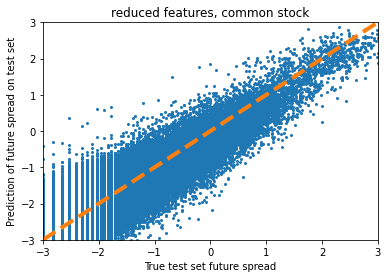

In [230]:
reduced_training_features=['log_ordinal_times', 'log_median_width', 'log_spread']
target='log_fut_spread'
symbol_type='Common Stock'
testsize=0.1

x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], reduced_training_features, target, testsize)
Predictor=Ridge(alpha, normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol_type']==symbol_type)][target].std())

print('the coefficient of log(ordinal_times) is...', Predictor.coef_[0])
print('the coefficient of log(median_width) is...', Predictor.coef_[1])
print('the coefficient of log(spread) is...',Predictor.coef_[2])

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([-3,10],[-3,10], ls='--', LineWidth=4)
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('reduced features, common stock')
plt.show()

the error is... 0.3789058825653527
the coefficient of log(ordinal_times) is... -0.027429619695273782
the coefficient of log(median_width) is... 0.46776593715765347
the coefficient of log(spread) is... 0.46638591118839107


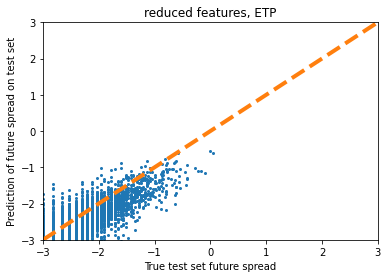

In [99]:
reduced_training_features=['log_ordinal_times', 'log_median_width', 'log_spread']
target='log_fut_spread'
symbol_type='ETP'
testsize=0.1

x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], reduced_training_features, target, testsize)
Predictor=Ridge(alpha, normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol_type']==symbol_type)][target].std())

print('the coefficient of log(ordinal_times) is...', Predictor.coef_[0])
print('the coefficient of log(median_width) is...', Predictor.coef_[1])
print('the coefficient of log(spread) is...',Predictor.coef_[2])

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([-3,10],[-3,10], ls='--', LineWidth=4)
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('reduced features, ETP')
plt.show()

the error is... 0.3075072956840754
the coefficient of log(ordinal_times) is... -0.03795461986099492
the coefficient of log(median_width) is... 0.5395636122970947
the coefficient of log(spread) is... 0.439956050664349


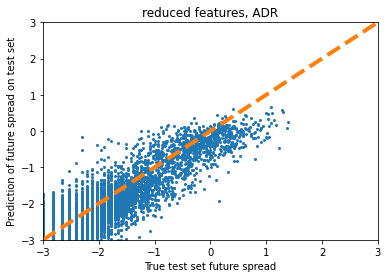

In [101]:
reduced_training_features=['log_ordinal_times', 'log_median_width', 'log_spread']
target='log_fut_spread'
symbol_type='ADR'
testsize=0.1

x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol_type']==symbol_type], reduced_training_features, target, testsize)
Predictor=Ridge(alpha, normalize=True).fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print('the error is...',RMSE/DataSet[(DataSet['symbol_type']==symbol_type)][target].std())

print('the coefficient of log(ordinal_times) is...', Predictor.coef_[0])
print('the coefficient of log(median_width) is...', Predictor.coef_[1])
print('the coefficient of log(spread) is...',Predictor.coef_[2])

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')
plt.plot([-3,10],[-3,10], ls='--', LineWidth=4)
plt.ylabel('Prediction of future spread on test set')
plt.xlabel('True test set future spread')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('reduced features, ADR')
plt.show()

This represents a small improvement over the previous model.

## Implementing DNNs to fit future spread 
### a low bias, high variance (?) approach

One of the challenges with linear regression is that it imposes a model of the regression that may not be clearly justified. We observed earlier that there were many predictors in the data which featured non-linear relationships, but those could not be parsed out by a linear model, and without strong intuition, model selection becomes difficult.

To offset this, DNNs can provide us with the ability to fit non-linear relationships - after all, they are universal function generators. 

This approach has risks, however. The resulting model is difficult to interpret, and can be prone to overfitting. In addition, it is incredibly expensive to train. We will try to mollify these issues, but further work and improvements can definitely be achieved.

To fit a DNN, we will take data and feed it into a several layer neural network. We then train the model under a cross validation method in keras, and then analyze its results on a test set. I'll play around with various network topologies to see what fits the data the best.


Given enough computational resources and time, I would train the model by dropping symbol information from the data set, and one hot coding the symbol type, enabling the neural network to take advantage of information about the symbol type and throw away information about the symbol. This is justified per our linear regression insights.

However, due to lack of time, I'm directly fitting a single neural network to a single ticker.

I note that I'm training using mean absolute error as the objective function, rather than mean squared error. I believe this is justified due to the outliers we observed throughout the data set.

I'll start with a (features) x 64 x 64 x 1 net

In [231]:
##ideally, I would do something like this to the data set
tfDataSet=DataSet
one_hot_type=pd.get_dummies(tfDataSet['symbol_type'])
tfDataSet=tfDataSet.drop('symbol', axis=1)
tfDataSet=tfDataSet.drop('symbol_type', axis=1)
tfDataSet=tfDataSet.join(one_hot_type)

type_one_hot_features=list(one_hot_type.columns)

tfStatic=staticFeatures+type_one_hot_features
tfNumeric=allNumericalFeatures+type_one_hot_features

tfStatic.remove('recip_ordinal_times')
tfNumeric.remove('recip_ordinal_times')
tfDataSet.head()

,ordinal_times,localtime,bid,ask,bidsize,asksize,mid,spread,open,high,...,log_median_width,log_spread,ADR,Common Stock,ETP,Ltd Part,MLP,NY Reg Shrs,REIT,Tracking Stk
0,0,2021-01-04 14:30:00+00:00,68.56,68.67,205,1,68.615,0.11,68.74,68.77,...,-4.605170,-2.207275,0,1,0,0,0,0,0,0
1,0,2021-01-04 14:30:00+00:00,88.71,89.05,17,452,88.880,0.34,88.93,89.05,...,-2.995732,-1.078810,0,1,0,0,0,0,0,0
2,0,2021-01-04 14:30:00+00:00,24.92,24.96,160,1300,24.940,0.04,25.00,25.05,...,-4.605170,-3.218876,0,1,0,0,0,0,0,0
3,0,2021-01-04 14:30:00+00:00,212.19,212.42,200,300,212.305,0.23,212.97,213.00,...,-2.207275,-1.469676,0,0,1,0,0,0,0,0
4,0,2021-01-04 14:30:00+00:00,45.46,45.50,300,200,45.480,0.04,45.90,45.90,...,-3.912023,-3.218876,0,1,0,0,0,0,0,0


I'll implement this for 100 random tickers in the data, and show the RMSE (standardized by the standard deviation of the future spread), as I have before for both fits to only static features and all features.

In [ ]:
import random
random_tickers=random.sample(tickers, 30)

In [180]:
def build_and_compile_model(norm):
    ##baseline model for DNN fitting. Loss can be changed to mean squared error or mean absolute error
    
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [ ]:
target='fut_spread'
static_RMSE={}

x_train, x_test, y_train, y_test=splitData(tfDataSet, tfStatic, target, 0.1, set_seed=False)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))



dnn_model = build_and_compile_model(normalizer)

dnn_model.summary()

history = dnn_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)
    
y_test_pred = dnn_model.predict(x_test).flatten()

error = (y_test_pred - y_test)**2
    
est_std=(np.sqrt(error.sum()/len(y_test)))
    
static_RMSE[ticker]=est_std/tfDataSet[target].std()
    
    #print(static_RMSE[ticker])

Model: "sequential_860"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_862 (Normaliz  (None, 19)               39        
 ation)                                                          
                                                                 
 dense_2305 (Dense)          (None, 64)                1280      
                                                                 
 dense_2306 (Dense)          (None, 1)                 65        
                                                                 
Total params: 1,384
Trainable params: 1,345
Non-trainable params: 39
_________________________________________________________________


In [186]:
target='fut_spread'
static_RMSE={}



tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
tfAllNumerical=tfStatic+TandQFeatures

for ticker in tqdm(random_tickers):

    tfDataSet=DataSet[DataSet['symbol']==ticker]
    tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']

    x_train, x_test, y_train, y_test=splitData(tfDataSet, tfStatic, target, 0.1, set_seed=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(x_train))



    dnn_model = build_and_compile_model(normalizer)

    history = dnn_model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=100)
    
    y_test_pred = dnn_model.predict(x_test).flatten()

    error = (y_test_pred - y_test)**2
    
    est_std=(np.sqrt(error.sum()/len(y_test)))
    
    static_RMSE[ticker]=est_std/tfDataSet[target].std()
    
    #print(static_RMSE[ticker])

100%|██████████| 30/30 [03:31<00:00,  7.05s/it]


In [187]:
static_RMSE

{'V': 0.7300215061708799,
 'RJF': 0.7174693133537394,
 'CE': 0.7938538782851419,
 'REG': 0.7351951626472836,
 'MRNA': 0.8448021308995065,
 'CDNS': 0.6691776109359517,
 'LAD': 0.7377537129046952,
 'SCHW': 1.3505936238040404,
 'RF': 1.207706803780027,
 'BILI': 0.8026122460048527,
 'MHK': 0.7242462137695148,
 'PXD': 0.6629528843737764,
 'BURL': 0.9412138609790619,
 'MGK': 0.9608797667384101,
 'CRM': 0.9251475066550189,
 'MS': 0.8969210592570479,
 'ODFL': 0.8999054080622332,
 'KMB': 0.8124976916362028,
 'GS': 0.7638284831220259,
 'CG': 0.8002174832501937,
 'SBNY': 0.8683682711610621,
 'NVS': 0.8824024370524373,
 'VUG': 0.8944940920771699,
 'LNC': 0.9981749323750705,
 'ANSS': 0.6765579248794078,
 'VLO': 0.7208521833928516,
 'FAST': 0.6922347008208346,
 'COST': 0.7766416001104451,
 'SLF': 1.0175189016920179,
 'PSA': 0.7317215680220893}

the median rmse is... 0.8014148646275232


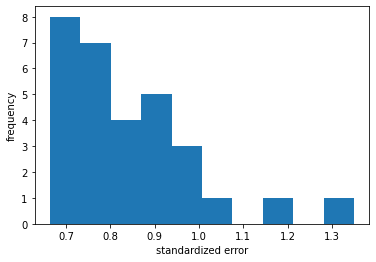

In [188]:
print('the median rmse is...', np.median(list(static_RMSE.values())))
plt.hist(static_RMSE.values())
plt.xlabel('standardized error')
plt.ylabel('frequency')
plt.show()

We observe some pretty poor performances. This implies that the neural net is failing to discover what our linear regression could discover.

We'll reduce the model to be in (input features) x 8 x 8 x 1, effectively making our deep net 'skinnier' to see if overfitting is the problem.

In [189]:
def build_and_compile_model(norm):
    ##baseline model for DNN fitting. Loss can be changed to mean squared error or mean absolute error
    
    model = keras.Sequential([
        norm,
        layers.Dense(8, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [190]:
tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
tfAllNumerical=tfStatic+TandQFeatures

for ticker in tqdm(random_tickers):

    tfDataSet=DataSet[DataSet['symbol']==ticker]
    tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']

    x_train, x_test, y_train, y_test=splitData(tfDataSet, tfStatic, target, 0.1, set_seed=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(x_train))



    dnn_model = build_and_compile_model(normalizer)

    history = dnn_model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=100)
    
    y_test_pred = dnn_model.predict(x_test).flatten()

    error = (y_test_pred - y_test)**2
    
    est_std=(np.sqrt(error.sum()/len(y_test)))
    
    static_RMSE[ticker]=est_std/tfDataSet[target].std()
    
    #print(static_RMSE[ticker])

100%|██████████| 30/30 [03:32<00:00,  7.09s/it]


In [191]:
static_RMSE

{'V': 0.8264525302088764,
 'RJF': 0.7633608358397288,
 'CE': 0.6814684036854463,
 'REG': 0.6685487144979928,
 'MRNA': 0.7864384179532126,
 'CDNS': 0.7234215051785731,
 'LAD': 0.6891210446238344,
 'SCHW': 0.9714330915500117,
 'RF': 1.5349451385882462,
 'BILI': 0.862340761088234,
 'MHK': 0.683144509004152,
 'PXD': 0.7132061713717709,
 'BURL': 0.7567908565708228,
 'MGK': 0.932878582660603,
 'CRM': 0.7881909497858515,
 'MS': 1.1516431443765176,
 'ODFL': 0.7054575817848495,
 'KMB': 0.7064140394363553,
 'GS': 0.7165312241520637,
 'CG': 0.7868494614293496,
 'SBNY': 0.8445210407319136,
 'NVS': 0.7142946605064008,
 'VUG': 1.041241642193592,
 'LNC': 0.9901915014243776,
 'ANSS': 0.6701206348679715,
 'VLO': 0.7598420940801357,
 'FAST': 0.7314436856503479,
 'COST': 0.8036167187548215,
 'SLF': 1.0757068507375989,
 'PSA': 0.8084245889899293}

the median rmse is... 0.7748996268964707


Text(0, 0.5, 'frequency')

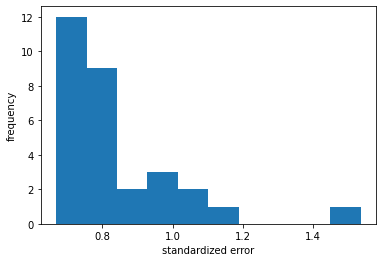

In [192]:
print('the median rmse is...',np.median(list(static_RMSE.values())))
plt.hist(static_RMSE.values())
plt.xlabel('standardized error')
plt.ylabel('frequency')

Surprisingly, in spite of the model being 1/64 'skinnier', the validation errors remained pretty stable. This suggests that overfitting due to depth might not be a problem.

Finally, I'll try a shallow, but wide net, and compare that to our deeper, but skinny net.

This net will be (features) x 64 x 1

In [193]:
##shallow but wide
def build_and_compile_model(norm):
    ##baseline model for DNN fitting. Loss can be changed to mean squared error or mean absolute error
    
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [194]:
tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
tfAllNumerical=tfStatic+TandQFeatures

for ticker in tqdm(random_tickers):

    tfDataSet=DataSet[DataSet['symbol']==ticker]
    tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']

    x_train, x_test, y_train, y_test=splitData(tfDataSet, tfStatic, target, 0.1, set_seed=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(x_train))



    dnn_model = build_and_compile_model(normalizer)

    history = dnn_model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=100)
    
    y_test_pred = dnn_model.predict(x_test).flatten()

    error = (y_test_pred - y_test)**2
    
    est_std=(np.sqrt(error.sum()/len(y_test)))
    
    static_RMSE[ticker]=est_std/tfDataSet[target].std()
    
    #print(static_RMSE[ticker])

100%|██████████| 30/30 [03:49<00:00,  7.64s/it]


In [195]:
static_RMSE

{'V': 1.1297449795931427,
 'RJF': 0.6763460117765888,
 'CE': 0.7490489170352107,
 'REG': 0.7963474156376437,
 'MRNA': 0.7864614734776304,
 'CDNS': 0.6426899089517991,
 'LAD': 0.6339718747763663,
 'SCHW': 1.1624580228213734,
 'RF': 9.32337311962517,
 'BILI': 0.873048526999434,
 'MHK': 0.6900131819300291,
 'PXD': 0.7280395958104654,
 'BURL': 0.7376237053570188,
 'MGK': 0.9425265517983321,
 'CRM': 0.8772580672540846,
 'MS': 1.696106071045408,
 'ODFL': 0.680962243926226,
 'KMB': 0.7920735038478781,
 'GS': 0.795296810258189,
 'CG': 1.037276287948349,
 'SBNY': 0.8487520013045469,
 'NVS': 1.1498789332895112,
 'VUG': 1.1666241150324992,
 'LNC': 0.7233652210689787,
 'ANSS': 0.6943929580300338,
 'VLO': 0.9981250683966041,
 'FAST': 1.0711053832744224,
 'COST': 0.9409074439208521,
 'SLF': 1.5448816355672192,
 'PSA': 0.9074307213063744}

the median rmse is... 0.8609002641519905


Text(0, 0.5, 'frequency')

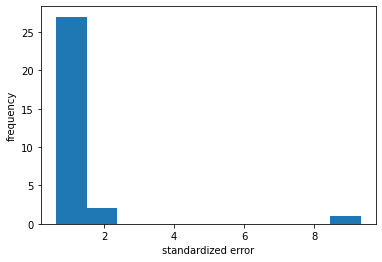

In [196]:
print('the median rmse is...',np.median(list(static_RMSE.values())))
plt.hist(static_RMSE.values())
plt.xlabel('standardized error')
plt.ylabel('frequency')

Based on our results, on median, a skinny but deep net seems preferable. However, in general, we see that tickers that are poorly trained in one DNN are poorly trained in the ther and vice versa for tickers that are well trained. This suggests that some tickers are simply more readily learned and can be predicted. 

We will now move on to using all features to see if this provides an improvement in performance.

Again, starting with a (allFeatures) x 64 x 64 x 1 net.

100%|██████████| 30/30 [04:08<00:00,  8.28s/it]

{'V': 1.007045941522511, 'RJF': 0.6835701243494458, 'CE': 0.8390386769944707, 'REG': 0.6911904317231996, 'MRNA': 0.747720602247587, 'CDNS': 0.721820147587883, 'LAD': 0.7545247899353712, 'SCHW': 1.0912507749079232, 'RF': 34.83796776947239, 'BILI': 0.9658766252842116, 'MHK': 0.7669129943483395, 'PXD': 0.7970716858905906, 'BURL': 0.7529604444148615, 'MGK': 1.0040644667147869, 'CRM': 0.7910137417917831, 'MS': 1.0536892288423692, 'ODFL': 0.7675921805788475, 'KMB': 0.6998830624734005, 'GS': 0.906194679529682, 'CG': 0.7908338538612497, 'SBNY': 0.7797605176173209, 'NVS': 0.7614076999152432, 'VUG': 0.8350277107415307, 'LNC': 0.8697508842141278, 'ANSS': 0.6934947014231047, 'VLO': 0.7328806772477404, 'FAST': 0.832871806410617, 'COST': 0.8371247527278552, 'SLF': 1.0146818767582753, 'PSA': 0.8478652746434592}
the median rmse is... 0.7940427138411869


Text(0, 0.5, 'frequency')

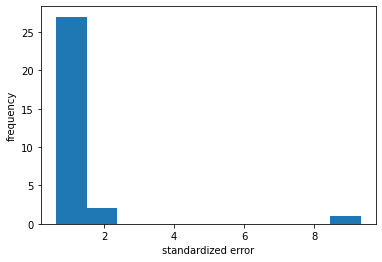

In [198]:
def build_and_compile_model(norm):
    ##baseline model for DNN fitting. Loss can be changed to mean squared error or mean absolute error
    
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

allNumerical_RMSE={}

tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
tfAllNumerical=tfStatic+TandQFeatures

for ticker in tqdm(random_tickers):

    tfDataSet=DataSet[DataSet['symbol']==ticker]
    tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']

    x_train, x_test, y_train, y_test=splitData(tfDataSet, tfAllNumerical, target, 0.1, set_seed=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(x_train))



    dnn_model = build_and_compile_model(normalizer)

    history = dnn_model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=100)
    
    y_test_pred = dnn_model.predict(x_test).flatten()

    error = (y_test_pred - y_test)**2
    
    est_std=(np.sqrt(error.sum()/len(y_test)))
    
    allNumerical_RMSE[ticker]=est_std/tfDataSet[target].std()
    
    #print(static_RMSE[ticker])
    
print(allNumerical_RMSE)
print('the median rmse is...',np.median(list(allNumerical_RMSE.values())))
plt.hist(static_RMSE.values())
plt.xlabel('standardized error')
plt.ylabel('frequency')

Now considering a skinny model...

100%|██████████| 30/30 [03:42<00:00,  7.41s/it]

{'V': 0.8420230671888067, 'RJF': 0.8020144546185477, 'CE': 0.7379658925487131, 'REG': 0.6874947146457996, 'MRNA': 0.7230002350216421, 'CDNS': 0.7100645246828801, 'LAD': 0.7621607540947739, 'SCHW': 1.055567795576395, 'RF': 3.591150218246472, 'BILI': 0.7956503295654013, 'MHK': 0.7086088570366091, 'PXD': 0.7175904218957169, 'BURL': 0.8090716725346352, 'MGK': 0.8674761762390124, 'CRM': 0.9301555362242009, 'MS': 1.0785537990269503, 'ODFL': 0.7059971873189809, 'KMB': 0.6469737163157614, 'GS': 0.7939202015748829, 'CG': 0.7423420650519061, 'SBNY': 0.8121164297200837, 'NVS': 0.8876473802036255, 'VUG': 1.0870538748282856, 'LNC': 0.6627456336866802, 'ANSS': 0.6733045358644016, 'VLO': 0.7052774582312831, 'FAST': 0.8649487441049666, 'COST': 0.8012701843483234, 'SLF': 1.2432314637161654, 'PSA': 0.8064316400035605}
the median rmse is... 0.7984602569568624


Text(0, 0.5, 'frequency')

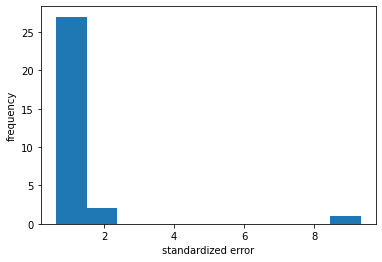

In [199]:
def build_and_compile_model(norm):
    ##baseline model for DNN fitting. Loss can be changed to mean squared error or mean absolute error
    
    model = keras.Sequential([
        norm,
        layers.Dense(8, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

allNumerical_RMSE={}

tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
tfAllNumerical=tfStatic+TandQFeatures

for ticker in tqdm(random_tickers):

    tfDataSet=DataSet[DataSet['symbol']==ticker]
    tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']

    x_train, x_test, y_train, y_test=splitData(tfDataSet, tfAllNumerical, target, 0.1, set_seed=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(x_train))



    dnn_model = build_and_compile_model(normalizer)

    history = dnn_model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=100)
    
    y_test_pred = dnn_model.predict(x_test).flatten()

    error = (y_test_pred - y_test)**2
    
    est_std=(np.sqrt(error.sum()/len(y_test)))
    
    allNumerical_RMSE[ticker]=est_std/tfDataSet[target].std()
    
    #print(static_RMSE[ticker])
    
print(allNumerical_RMSE)
print('the median rmse is...',np.median(list(allNumerical_RMSE.values())))
plt.hist(static_RMSE.values())
plt.xlabel('standardized error')
plt.ylabel('frequency')

Now considering a wide model...

100%|██████████| 30/30 [04:00<00:00,  8.00s/it]

{'V': 1.1920062134324745, 'RJF': 0.722904861686301, 'CE': 0.724976118483023, 'REG': 0.8731243447524417, 'MRNA': 0.8230680364953273, 'CDNS': 0.7215240359392119, 'LAD': 0.6412089257279361, 'SCHW': 1.439676507554992, 'RF': 20.95927507631966, 'BILI': 0.857673252323675, 'MHK': 0.7063029640796556, 'PXD': 0.7179715172829982, 'BURL': 0.7501745520765083, 'MGK': 1.0515105797422113, 'CRM': 0.8906228298765386, 'MS': 1.7184395434194464, 'ODFL': 0.6838200352706325, 'KMB': 0.7992983544843808, 'GS': 0.8650993875248785, 'CG': 1.086660223674317, 'SBNY': 0.7290972382989824, 'NVS': 1.4717287186514691, 'VUG': 1.0309343962234128, 'LNC': 0.8761624097558323, 'ANSS': 0.6455380615940806, 'VLO': 1.2710721615535343, 'FAST': 1.541709883183504, 'COST': 0.8527030598998032, 'SLF': 1.5507001833124556, 'PSA': 0.760662629430528}
the median rmse is... 0.8613863199242767


Text(0, 0.5, 'frequency')

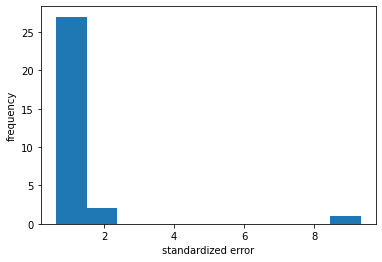

In [200]:
def build_and_compile_model(norm):
    ##baseline model for DNN fitting. Loss can be changed to mean squared error or mean absolute error
    
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

allNumerical_RMSE={}

tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
tfAllNumerical=tfStatic+TandQFeatures

for ticker in tqdm(random_tickers):

    tfDataSet=DataSet[DataSet['symbol']==ticker]
    tfStatic=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])+['ordinal_times']

    x_train, x_test, y_train, y_test=splitData(tfDataSet, tfAllNumerical, target, 0.1, set_seed=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(x_train))



    dnn_model = build_and_compile_model(normalizer)

    history = dnn_model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=100)
    
    y_test_pred = dnn_model.predict(x_test).flatten()

    error = (y_test_pred - y_test)**2
    
    est_std=(np.sqrt(error.sum()/len(y_test)))
    
    allNumerical_RMSE[ticker]=est_std/tfDataSet[target].std()
    
    #print(static_RMSE[ticker])
    
print(allNumerical_RMSE)
print('the median rmse is...',np.median(list(allNumerical_RMSE.values())))
plt.hist(static_RMSE.values())
plt.xlabel('standardized error')
plt.ylabel('frequency')

Overall, it seems that DNNs tend to regress this data fairly poorly compared to more conventional methods. It's possible, however, if I had the computational resources to fit all of the symbols simultaneously, or all of the symbols within a particular symbol type simultaneously, this DNN would also be able to discover the structure we observed in the linear regression model. In addition, we might then potentially be able to see other structures emerge.

## Conclusion

There are several conclusions that can be drawn from the data. First, there is a stereotypical fall off of spread against time throuhgout the day, that is conserved across assets within a particular symbol type. This data collapse suggests that we can think about asset classes more broadly, rather than thinking about particular tickers. Second, many of the relationships within the data are non-linear, but median width, spread, and closing price all seem to have strong linear relationships with future spread. Third, the data can be categorized into different clusters, depending on the volume and volatility of each ticker, but these clusters are not determined in a straightforward manner.

It appears that I have two intriguing simple models that explain much of the variance of our model. However, fitting these linear models required many simplifying assumptions, which have no clear mechanistic justification. Further exploration would be necessary to understand whether or not the proposed models continue to hold up in the real world. In addition, a significant limitation of my linear model is the marginal improvement in performance through the use of trade and quote information. Typically, one would expect significant benefits from using such data, but the linear regression models did not show such a gain. This reflects that there are deeper, more non-linear relationships to be explored.

To explore these non-linear relations, deep neural networks are particularly attractive, as they can generate any function. From my deep nets, I was able not able to find any improvements. This may be a consequence of poor training, as a result of only being able to train on one symbol at a time. Potential improvements could still be achieved with more computatoinal resources.

Not shown here are attempts to fit the data using Random Forest Regressors and Gradient Boosting Regressors. These seem like attractive models, as they serve as high dimensional clustering algorithms, and can readily be translated into machinery that could be used to guide a trader's decision making. However, I struggled to train these on my laptop - repeatedly crashing my computer, even for very small histogram-based gradient boosting regressors. I suspect, however, there are large opportunities to improve on performance using these kinds of models.

In addition, I attempted to use PCA to attempt to reduce the correlation structure in the data, but ultimately, found that it wasn't super useful. Usually, it's a good idea to implement PCA on data before putting it into a regression model to prevent some features from becoming redundant, but my efforts on this front did not pan out.

I just want to end off by thanking the readers at Old Mission Capital. This was honestly a really fun project, and I enjoyed getting to try all of these different techniques. Working with real data with no a priori known (to me) structure is a fairly new experience to me, coming from a research environment with largely simulated data or data from systems with clear mechanistic relationships, and then implementing all these various regression techniques on the data was quite the learning experience. I would thoroughly appreciate feedback from the reviewers to learn what mistakes I made, what things I should have considered, and how else I should have thought about the data!

shouldn't have randomized train test, caused data leakage where I struggled.

custom metric was misleading

should always try to go return space

normalize by price
Okay I 